<a href="https://colab.research.google.com/github/maaziya77/AI_Search_Project/blob/main/AI_Search_Algorithms_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_excel("/content/japan_cities.csv.xlsx")
df = df.rename(columns={
    "city name": "city",
    "latitude": "lat",
    "longtitude": "lon"
})
df["city"] = df["city"].astype(str).str.strip()
df = df.dropna(subset=["lat", "lon"]).drop_duplicates(subset=["city"]).reset_index(drop=True)



In [ ]:
#BFS-hamad

df = df.rename(columns={
    "city name": "city",
    "latitude": "lat",
    "longtitude": "lon"   # <-- use "longtitude", not "longitude"
})

df["city"] = df["city"].astype(str).str.strip()
df = df.dropna(subset=["lat", "lon"]).drop_duplicates(subset=["city"]).reset_index(drop=True)
df.head()
from math import radians, sin, cos, asin, sqrt

def haversine_km(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in km
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1)*cos(lat2)*sin(dlon/2)**2
    return 2 * R * asin(sqrt(a))


K = 8
coords = df[["lat","lon"]].to_numpy()
N = len(df)
adj = [[] for _ in range(N)]  # adjacency list: (neighbor, distance)

for i in range(N):
    lat1, lon1 = coords[i]
    dists = []
    for j in range(N):
        if i == j: continue
        lat2, lon2 = coords[j]
        d = haversine_km(lat1, lon1, lat2, lon2)
        dists.append((d, j))
    dists.sort(key=lambda x: x[0])
    for d, j in dists[:K]:
        adj[i].append((j, d))
        adj[j].append((i, d))  # make graph undirected

print("Graph built with", N, "cities and", sum(len(x) for x in adj)//2, "edges")


def find_city_index(name):
    name = name.lower()
    exact = df.index[df["city"].str.lower() == name]
    if len(exact): return int(exact[0])
    contains = df.index[df["city"].str.lower().str.contains(name)]
    return int(contains[0]) if len(contains) else None

from collections import deque
import time

def bfs(start, goal, adj):
    t0 = time.time()
    frontier = deque([start])
    parent = {start: None}
    expanded = 0

    while frontier:
        u = frontier.popleft()
        expanded += 1
        if u == goal:
            break
        for v, _ in adj[u]:
            if v not in parent:
                parent[v] = u
                frontier.append(v)

    path = []
    if goal in parent:
        cur = goal
        while cur is not None:
            path.append(cur)
            cur = parent[cur]
        path.reverse()
    t1 = time.time()
    return path, expanded, t1 - t0


def path_cost(path, adj):
    total = 0.0
    for a,b in zip(path, path[1:]):
        w = next(w for v,w in adj[a] if v==b)
        total += w
    return total

path, expanded, runtime = bfs(start_idx, goal_idx, adj)
cost = path_cost(path, adj)

print("\n")
print("Breadth first search method:")

print("Path length :", len(path)-1)
print("Cost (km):", round(cost,2))
print("Nodes expanded:", expanded)
print("Execution time (s):", round(runtime,4))

# Show first 20 cities along the path
#[df.loc[i,"city"] for i in path[:20]]



Graph built with 1257 cities and 10056 edges


Breadth first search method:
Path length : 52
Cost (km): 2494.61
Nodes expanded: 1246
Execution time (s): 0.0043


In [ ]:
#GREEDY Best first search-rana

import math, heapq, pandas as pd
from collections import defaultdict
from dataclasses import dataclass, field

#Harversine distance
def haversine(lat1, lon1, lat2, lon2, R=6371.0):

    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (lon2 - lon1) * math.pi / 180.0

    lat1 = lat1 * math.pi / 180.0
    lat2 = lat2 * math.pi / 180.0

    a = (math.sin(dLat/2)**2 +
     math.cos(lat1) * math.cos(lat2) * math.sin(dLon/2)**2)

    c = 2 * math.asin(math.sqrt(a))
    rad = 6371  # Earth radius in km

    return rad * c


# Build Graph
def build_knn_graph(df, k=8):
    cities = sorted(df["city"].tolist())
    coords = {r.city: (float(r.lat), float(r.lon)) for _, r in df.iterrows()}
    graph = {c: [] for c in cities}
    seen = {c: set() for c in cities}

    for c1 in cities:
        lat1, lon1 = coords[c1]
        dists = []
        for c2 in cities:
            if c1 == c2:
                continue
            lat2, lon2 = coords[c2]
            d = haversine(lat1, lon1, lat2, lon2)
            dists.append((d, c2))
        dists.sort(key=lambda x: (x[0], x[1]))  # distance, then name

        for d, nbr in dists[:k]:
            if nbr not in seen[c1]:
                graph[c1].append((nbr, d))
                seen[c1].add(nbr)
            if c1 not in seen[nbr]:
                graph[nbr].append((c1, d))
                seen[nbr].add(c1)
    for c in graph:
        graph[c].sort(key=lambda x: (x[0], x[1]))
    return graph, coords


# node and priority queue
@dataclass(order=True)
class Node:
    priority: float = field(init=False, repr=False)
    state: any
    parent: any
    action: any
    gcost: float
    hcost: float
    def __post_init__(self): self.priority = self.hcost

class PQueueFrontier:
    def __init__(self): self.heap=[]; self._ctr=0
    def add(self, node): self._ctr+=1; heapq.heappush(self.heap,(node.priority,self._ctr,node))
    def empty(self): return not self.heap
    def remove(self): return heapq.heappop(self.heap)[2]

#Route problem
class RouteProblem:
    def __init__(self, start, goal, graph, coords):
        self.start = start
        self.goal = goal
        self.graph = graph
        self.coords = coords

    def goal_test(self, state): return state == self.goal
    def result(self, state): return [(nbr, nbr) for nbr, _ in self.graph[state]]
    def path_cost(self, s1, s2):
        for nbr, w in self.graph[s1]:
            if nbr == s2: return w
        return haversine(*self.coords[s1], *self.coords[s2])
    def heuristic(self, state):
        lat1, lon1 = self.coords[state]
        latg, longg = self.coords[self.goal]
        return haversine(lat1, lon1, latg, longg)
#Graph search problem
def graph_search_cost(problem, algo):
    start = Node(state=problem.start, parent=None, action=None, gcost=0, hcost=problem.heuristic(problem.start))
    frontier = PQueueFrontier(); frontier.add(start)
    explored = set()
    while True:
        if frontier.empty():
            raise Exception("No solution found.")
        node = frontier.remove()
        explored.add(node.state)
        if problem.goal_test(node.state):
            path = []
            while node:
                path.append(node.state)
                node = node.parent
            return list(reversed(path)), explored
        for action, state in problem.result(node.state):
            if state not in explored:
                if algo == 'ucs':
                    child = Node(state=state, parent=node, action=action,
                                 gcost=node.gcost + problem.path_cost(node.state, state),
                                 hcost=0)
                elif algo == 'greedy':
                    child = Node(state=state, parent=node, action=action,
                                 gcost=0,
                                 hcost=problem.heuristic(state))
                elif algo == 'a*':
                    child = Node(state=state, parent=node, action=action,
                                 gcost=node.gcost + problem.path_cost(node.state, state),
                                 hcost=problem.heuristic(state))
                frontier.add(child)

#path cost
def path_cost_km(path, coords):
    total = 0.0
    for i in range(len(path) - 1):
        total += haversine(*coords[path[i]], *coords[path[i + 1]])
    return total

#Running greedy best first search

graph, coords = build_knn_graph(df, k=8)
problem = RouteProblem("Makurazaki", "Nemuro", graph, coords)

path, explored = graph_search_cost(problem, "greedy")

print("Greedy Best-First method:")

hops = len(path) - 1
total_dist = path_cost_km(path, coords)
print("Path length:", hops)
print("Cost (km):", round(total_dist, 2))
print("Nodes expanded:", len(explored))
print("Execution time (s):", round(runtime,4))



Greedy Best-First method:
Path length: 55
Cost (km): 2575.32
Nodes expanded: 62
Execution time (s): 0.0039


In [ ]:
#A*-maaziya
import pandas as pd
import math
import heapq
import time

def haversine(coord1, coord2):
    R = 6371  # Earth radius in km
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.sin(dlon/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c

df = pd.read_excel("/content/japan_cities.csv.xlsx")  # your file path
df.columns = df.columns.str.strip()     # remove extra spaces in headers

city_coords = {row["city name"]: (row["latitude"], row["longtitude"]) for _, row in df.iterrows()}
vertices = list(city_coords.keys())


# 4. Build graph with k=8 neighbors
def build_graph(k=8):
    edges = []
    for city in vertices:
        distances = [(haversine(city_coords[city], city_coords[other]), other)
                     for other in vertices if other != city]
        distances.sort(key=lambda x: x[0])
        for dist, neighbor in distances[:k]:
            edges.append((city, neighbor, dist))
    return edges

edges = build_graph(k=8)


# 5. Classes
class GraphProblem():
    def __init__(self, vertices, edges, start, goal, heuristic_values=[]):
        self.vertices = vertices
        self.edges = edges
        self.start = start
        self.goal = goal
        self.heuristic_values = heuristic_values

    def initial_state(self):
        return self.start

    def goal_test(self, state):
        return state == self.goal

    def result(self, state):
        connected_actions = []
        for edge in self.edges:
            if edge[0] == state:
                connected_actions.append((edge[1], edge[1]))
            elif edge[1] == state:
                connected_actions.append((edge[0], edge[0]))
        connected_actions.sort()
        return connected_actions

    def path_cost(self, state, newstate):
        for edge in self.edges:
            if (edge[0] == state and edge[1] == newstate) or (edge[1] == state and edge[0] == newstate):
                return edge[2]
        return float('inf')

    def heuristic(self, state):
        return self.heuristic_values[self.vertices.index(state)]


class Node():
    def __init__(self, state, parent, action, gcost=0, hcost=0):
        self.state = state
        self.parent = parent
        self.action = action
        self.gcost = gcost
        self.hcost = hcost
    def __lt__(self, other):
        return self.gcost + self.hcost < other.gcost + other.hcost


class PQueueFrontier():
    def __init__(self):
        self.frontier = []
    def add(self, node):
        heapq.heappush(self.frontier, node)
    def contains_state(self, state):
        return any(node.state == state for node in self.frontier)
    def empty(self):
        return len(self.frontier) == 0
    def remove(self):
        if self.empty():
            raise Exception("empty frontier")
        else:
            node = heapq.heappop(self.frontier)
            return node


# 6. Optimized A* Search
def graph_search_a_star(problem):
    start = Node(state=problem.start, parent=None, action=None, gcost=0, hcost=problem.heuristic(problem.start))
    frontier = PQueueFrontier()
    frontier.add(start)
    explored = set()
    best_g = {problem.start: 0}

    while not frontier.empty():
        node = frontier.remove()

        # Goal check
        if problem.goal_test(node.state):
            actions, cells = [], []
            total_cost = node.gcost
            while node.parent is not None:
                actions.append(node.action)
                cells.append(node.state)
                node = node.parent
            actions.append(node.action)
            cells.append(node.state)
            actions.reverse()
            cells.reverse()
            return (actions, cells, total_cost), explored

        explored.add(node.state)

        # Expand neighbors
        for action, state in problem.result(node.state):
            new_cost = node.gcost + problem.path_cost(node.state, state)

            if state not in best_g or new_cost < best_g[state]:
                best_g[state] = new_cost
                child = Node(state=state, parent=node, action=action,
                             gcost=new_cost, hcost=problem.heuristic(state))
                frontier.add(child)

    return None, explored


#heuristics

start_city = "Makurazaki"
goal_city = "Nemuro"

# Heuristic 1: Straight-line Haversine
heuristic_values_h1 = [haversine(city_coords[v], city_coords[goal_city]) for v in vertices]

# Heuristic 2: Landmark-based (using Tokyo as landmark)
landmark_city = "Tokyo"   # <-- change this if needed
dist_from_landmark = {v: haversine(city_coords[landmark_city], city_coords[v]) for v in vertices}
dist_landmark_goal = dist_from_landmark[goal_city]
heuristic_values_h2 = [abs(dist_landmark_goal - dist_from_landmark[v]) for v in vertices]


# 8. Run A* with both heuristics

problem_h1 = GraphProblem(vertices, edges, start=start_city, goal=goal_city, heuristic_values=heuristic_values_h1)
problem_h2 = GraphProblem(vertices, edges, start=start_city, goal=goal_city, heuristic_values=heuristic_values_h2)

start_time = time.time()
solution_h1, explored_h1 = graph_search_a_star(problem_h1)
end_time = time.time()
print("A* with Heuristic 1 (Haversine):")
print("Path length:", len(solution_h1[1]))
print("Cost:", solution_h1[2])
print("Nodes Expanded:", len(explored_h1))
print("Execution Time: {:.4f} seconds".format(end_time - start_time))

print("\n---------------------------------------\n")

start_time = time.time()
solution_h2, explored_h2 = graph_search_a_star(problem_h2)
end_time = time.time()
print("A* with Heuristic 2 (Landmark - Tokyo):")
print("Path length:", len(solution_h2[1]))
print("Cost:", solution_h2[2])
print("Nodes Expanded:", len(explored_h2))
print("Execution Time: {:.4f} seconds".format(end_time - start_time))


A* with Heuristic 1 (Haversine):
Path length: 64
Cost: 2225.721992481162
Nodes Expanded: 1193
Execution Time: 9.5427 seconds

---------------------------------------

A* with Heuristic 2 (Landmark - Tokyo):
Path length: 64
Cost: 2225.721992481162
Nodes Expanded: 1255
Execution Time: 7.3675 seconds


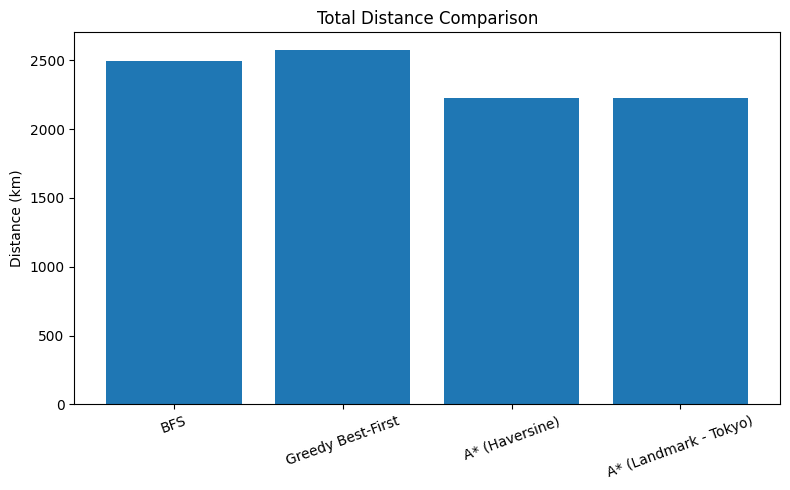

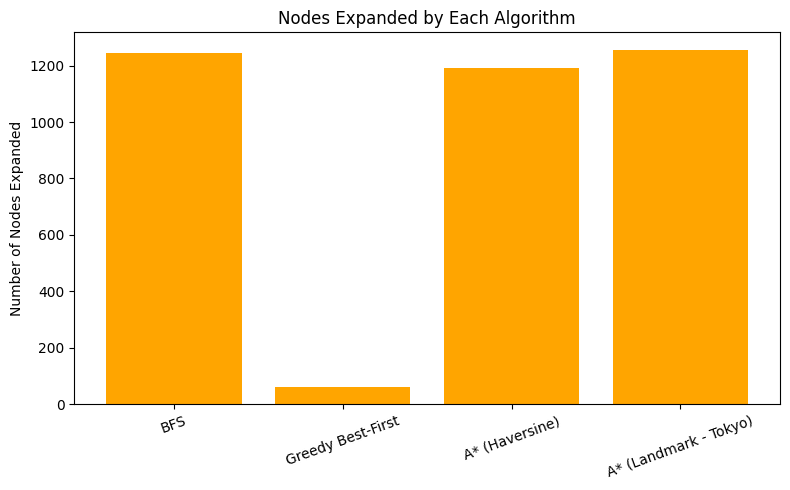

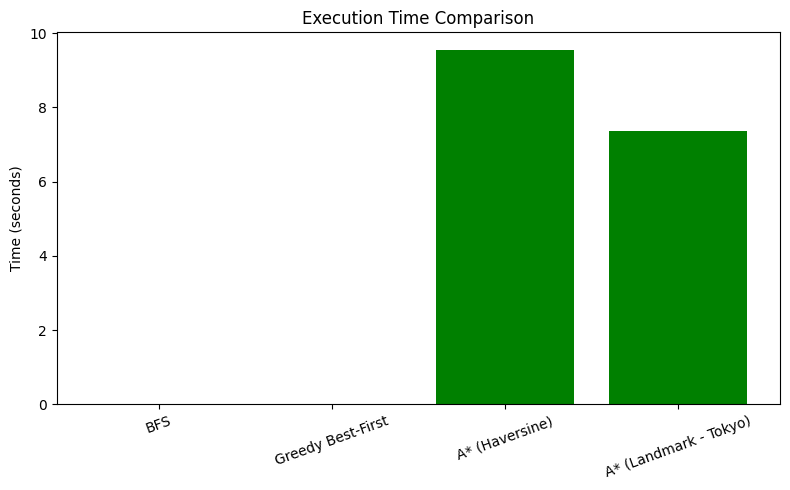

Algorithm,Path Length (hops),Total Distance (km),Nodes Expanded,Execution Time (s)
BFS,52,2494.610000,1246,0.004300
Greedy Best-First,53,2575.320000,62,0.003900
A* (Haversine),64,2225.720000,1193,9.542700
A* (Landmark - Tokyo),64,2225.720000,1255,7.367500


In [ ]:
#maaziya-comparison
import matplotlib.pyplot as plt
import pandas as pd

# === Step 1: Store your results ===
data = {
    "Algorithm": [
        "BFS",
        "Greedy Best-First",
        "A* (Haversine)",
        "A* (Landmark - Tokyo)"
    ],
    "Path Length (hops)": [52, 53, 64, 64],
    "Total Distance (km)": [2494.61, 2575.32, 2225.72, 2225.72],
    "Nodes Expanded": [1246, 62, 1193, 1255],
    "Execution Time (s)": [0.0043, 0.0039, 9.5427, 7.3675]
}

df = pd.DataFrame(data)

# === Step 2: Bar chart for total distance ===
plt.figure(figsize=(8,5))
plt.bar(df["Algorithm"], df["Total Distance (km)"])
plt.title("Total Distance Comparison")
plt.ylabel("Distance (km)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# === Step 3: Bar chart for nodes expanded ===
plt.figure(figsize=(8,5))
plt.bar(df["Algorithm"], df["Nodes Expanded"], color='orange')
plt.title("Nodes Expanded by Each Algorithm")
plt.ylabel("Number of Nodes Expanded")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# === Step 4: Bar chart for execution time ===
plt.figure(figsize=(8,5))
plt.bar(df["Algorithm"], df["Execution Time (s)"], color='green')
plt.title("Execution Time Comparison")
plt.ylabel("Time (seconds)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

# === Step 5: Optional summary table display ===
display(df.style.hide(axis='index').set_caption("Algorithm Performance Summary"))
